In [1]:
# Packages

import numpy as np
import matplotlib.pyplot as plt
import random

from utils import *
from environment import ButtonsToy
from learner import Learner
from teacher import BaysesianTeacher

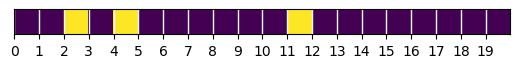

In [2]:
observation_env = ButtonsToy(20, 3)
observation_env.render()

## Learners

In [3]:
types = [0, 1, 2, 3]
traj_size = 60
N = 100
N_envs = 5
dict  = {}
for type in types:
    learner = Learner(type)
    dict[type] = {'actions' : [],
                  'rewards' : []}
    for _ in range(N_envs):
        observation_env = ButtonsToy(20, 3)
        for _ in range(N):
            learner.init_env(observation_env)
            actions, rewards = learner.act(traj_size)
            dict[type]['actions'].append(actions)
            dict[type]['rewards'].append(rewards)

/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/utils.py:26: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/utils.py:26: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


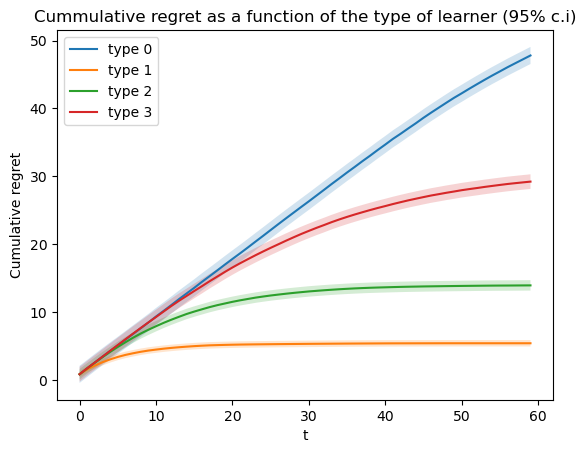

In [4]:
for ii,type in enumerate(types):
    all_rewards = np.array(dict[type]['rewards'])
    all_cum_regrets = np.cumsum(np.ones_like(all_rewards) - all_rewards, axis=1)
    mean, std = np.mean(all_cum_regrets, axis=0), np.std(all_cum_regrets)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(traj_size), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Cumulative regret')
    plt.xlabel('t')
    plt.title('Cummulative regret as a function of the type of learner (95% c.i)')
    plt.legend()

## Bayesian teacher

Observation environment


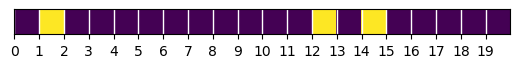

Demonstration environment


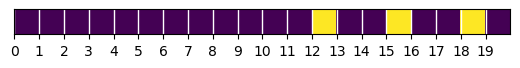

In [6]:
observation_env = ButtonsToy(20, 3)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(20, 3)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=3)
learner.init_env(observation_env)

### Predict learner type

In [10]:
N = 100
N_envs = 10
num_obs = 50

dict = {}

for type in range(num_types):
    dict[type] = []
    for _ in range(N_envs):
        # Init envs
        observation_env = ButtonsToy(20, 3)
        demonstration_env = ButtonsToy(20, 3)
        for _ in range(N):
            # Init teacher
            teacher = BaysesianTeacher(env=observation_env, 
                                    demonstration_env=demonstration_env, 
                                    num_types=num_types)
            # Init learner
            learner = Learner(type)
            learner.init_env(observation_env)

            accuracies = []
            for _ in range(num_obs):
                accuracies.append(type == teacher.predict_learner_type())
                teacher.observe(learner.act())
            dict[type].append(accuracies)

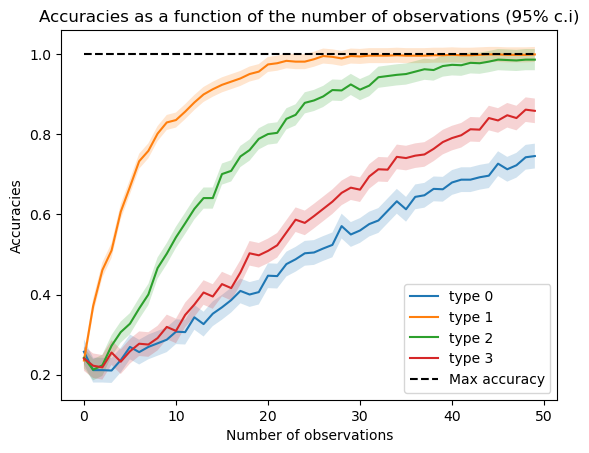

In [11]:
for type in range(num_types):
    accuracies = np.array(dict[type])
    mean, std = np.mean(accuracies, axis=0), np.std(accuracies)

    plt.plot(mean, label=f'type {type}')
    plt.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N * N_envs), mean - 1.96 * std / np.sqrt(N * N_envs), alpha=0.2)
    plt.ylabel('Accuracies')
    plt.xlabel('Number of observations')
    plt.title('Accuracies as a function of the number of observations (95% c.i)')
plt.plot(np.arange(num_obs), [1] * num_obs, c='k', label="Max accuracy", ls='--')
plt.legend();

### Demonstrate

Observation environment


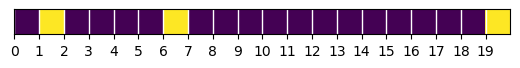

Demonstration environment


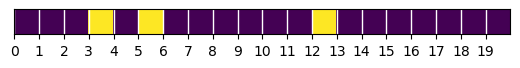

In [2]:
observation_env = ButtonsToy(20, 3)
print('Observation environment')
observation_env.render()
plt.show()

demonstration_env = ButtonsToy(20, 3)
print('Demonstration environment')
demonstration_env.render()
plt.show()

num_types = 4
teacher = BaysesianTeacher(env=observation_env, num_types=num_types)
learner = Learner(type=1)
learner.init_env(observation_env)

In [3]:
# Observe the learner
traj = learner.act(size=3)
teacher.observe(traj)
teacher.predict_learner_type()

/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/utils.py:26: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/utils.py:26: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)


3

In [4]:
# Infers the type of learner and demonstrates
print(teacher.beliefs)
teacher.init_env(demonstration_env)
demo = teacher.demonstrate(method='mean', alpha=0.015)

[0.25 0.25 0.25 0.25]


/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/learner.py:29: RuntimeWarning: invalid value encountered in divide
  updated_beliefs[a, :] /= updated_beliefs[a, :].sum()


In [5]:
# Show the demonstration
learner.init_env(demonstration_env)
learner.observe(demo)
# Evaluate hwo helpful has been the demonstration
actions, rewards = learner.act(size=20)
final_eval = np.sum(rewards)
print(final_eval)

20.0


In [31]:
N = 100
N_envs = 3
num_obs = 30

n_eval = 20

dict = {}
alpha_values = [0.01, 0.02]
method_values = ['argmax', 'mean']

for method in method_values:
    dict[method] = {}
    for alpha in alpha_values:
        dict[method][alpha] = {}
        for type in range(num_types):
            dict[method][alpha][type] = []
            for _ in range(N_envs):
                # Init envs
                observation_env = ButtonsToy(20, 3)
                demonstration_env = ButtonsToy(20, 3)
                for _ in range(N):
                    # Init teacher
                    teacher = BaysesianTeacher(env=observation_env,
                                            num_types=num_types)
                    # Init learner
                    learner = Learner(type)
                    learner.init_env(observation_env)

                    cum_rewards = []
                    for n in range(num_obs):
                        learner.init_env(observation_env)
                        # Observe the learner
                        traj = learner.act(size=n)
                        teacher.observe(traj)
                        # Infers the type of learner and chose demonstration
                        teacher.init_env(demonstration_env)
                        demo = teacher.demonstrate(method=method, alpha=alpha)
                        # Show the demonstration
                        learner.init_env(demonstration_env)
                        learner.observe(demo)
                        # Evaluate hwo helpful has been the demonstration
                        actions, rewards = learner.act(size=n_eval)
                        cum_rewards.append(np.sum(rewards))
                    dict[method][alpha][type].append(cum_rewards)

/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/utils.py:26: RuntimeWarning: divide by zero encountered in log2
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/utils.py:26: RuntimeWarning: invalid value encountered in multiply
  tab = proba_dist * np.log2(proba_dist)
/home/chetouani/Documents/STAGE_Clemence/STAGE_ISIR/CODE/experimental_setup_meta/learner.py:29: RuntimeWarning: invalid value encountered in divide
  updated_beliefs[a, :] /= updated_beliefs[a, :].sum()


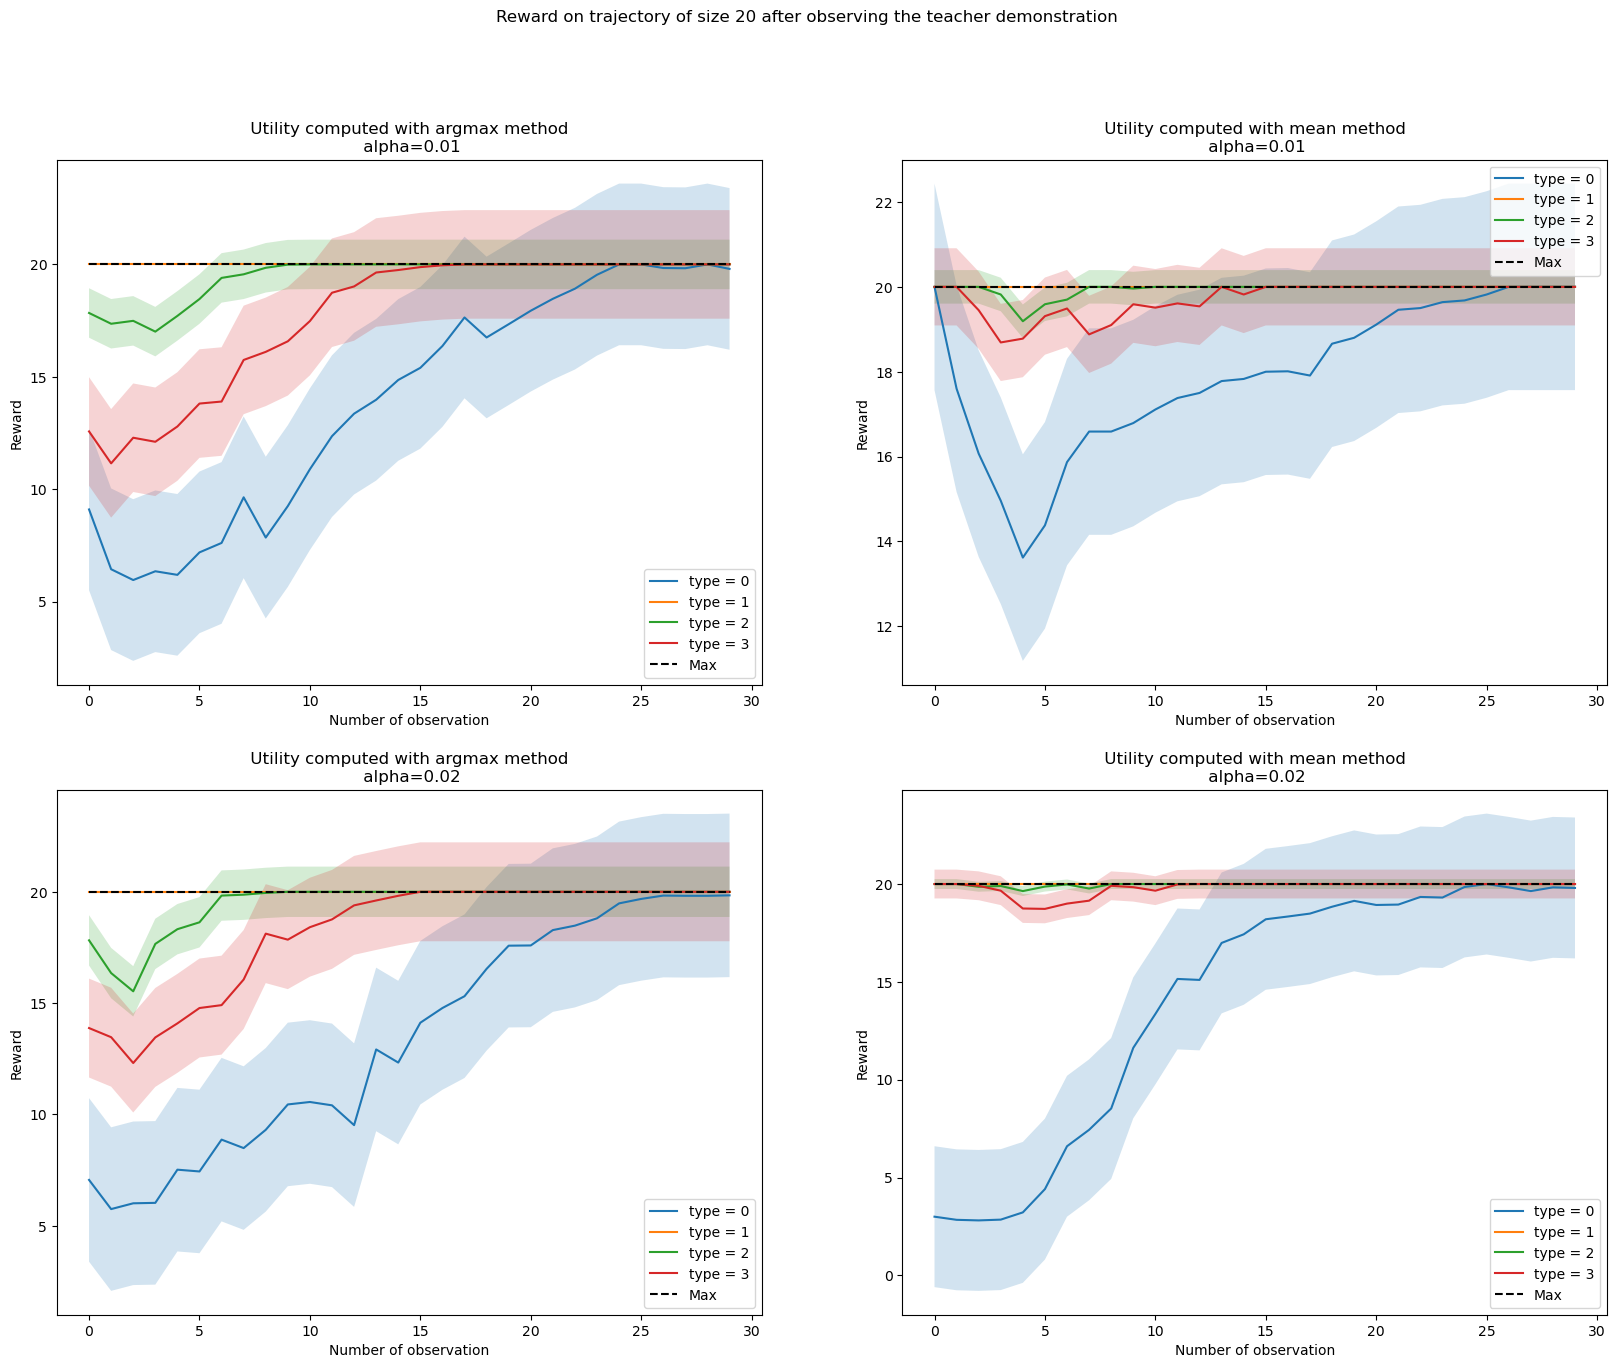

In [ ]:
fig, axes = plt.subplots(len(alpha_values), 2, figsize=(20,15))

for ii,alpha in enumerate(alpha_values):
    for jj,method in enumerate(method_values):
        ax = axes[ii, jj]
        for type in range(num_types):
            all_evals = np.array(dict[method][alpha][type])
            mean = np.mean(all_evals, axis=0)
            std = np.std(all_evals)

            ax.plot(mean, label=f'type = {type}')
            ax.fill_between(np.arange(num_obs), mean + 1.96 * std / np.sqrt(N + N_envs), mean - 1.96 * std/np.sqrt(N + N_envs), alpha=0.2)
        ax.plot(np.arange(num_obs), [20] * num_obs, c='k', label="Max", ls='--')
        ax.set_title(f' Utility computed with {method} method \n alpha={alpha}')
        ax.set_xlabel('Number of observation')
        ax.set_ylabel('Reward')
        ax.legend()
fig.suptitle(f'Reward on trajectory of size {n_eval} after observing the teacher demonstration');